# Object Detection

**Acknowledgements:**
1. [Tutorial](https://www.tensorflow.org/hub/tutorials/object_detection) on Colab.  
2. [Notebook](https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb) on Github.  

**References:**
1. TF resources:
   1. [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)  
   2. [Object detection module **FasterRCNN+InceptionResNet V2**](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1)  
   3. [Object detection module **ssd+mobilenet V2**](https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1)  
   
**Table of contents:**
1. [Setup](#Setup)  
2. [Image download and visualization functions](#Image-download-and-visualization-functions)  
3. [Apply module](#Apply-module)  
4. [Inference](#Inference)  

In [1]:
# For running inference on the TF-Hub module
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image
import matplotlib.pyplot as plt
import tempfile  # https://docs.python.org/3/library/tempfile.html
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time
import time

# TF version
print(tf.__version__)

# Check available GPUs
print('Available GPU devices: {}'.format(tf.test.gpu_device_name()))

2.2.0
Available GPU devices: /device:GPU:0


## Image download and visualization functions

Visualization code based on the [TF object decection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py).

In [2]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)
    

def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix='.jpg')
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height),
                             Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(filename, format='JPEG', quality=90)
    print('Image downloaded to {}'.format(filename))
    
    if display:
        display_image(pil_image)
    
    return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)
    
    # If the total height of the display strings added to the top
    # of the bounding box exceeds the top of the image, stack the
    # strings below the bounding box instead.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and a bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill='black',
                  font=font)
        text_bottom -= text_height - 2 * margin
        

def draw_boxes(image, boxes, class_names, scores, max_boxes=10,
               min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label images."""
    colors = list(ImageColor.colormap.values())
    
    try:
        font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
                                  25)
    except IOError:
        print('Font not found, using default font.')
        font = ImageFont.load_default()
        
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = '{}: {}%'.format(class_names[i].decode('ascii'),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
            draw_bounding_box_on_image(image_pil,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color,
                                       font,
                                       display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

## Apply module

Load a public image from Open Images v4, save locally, and display.

Image downloaded to /tmp/tmpm621h98j.jpg


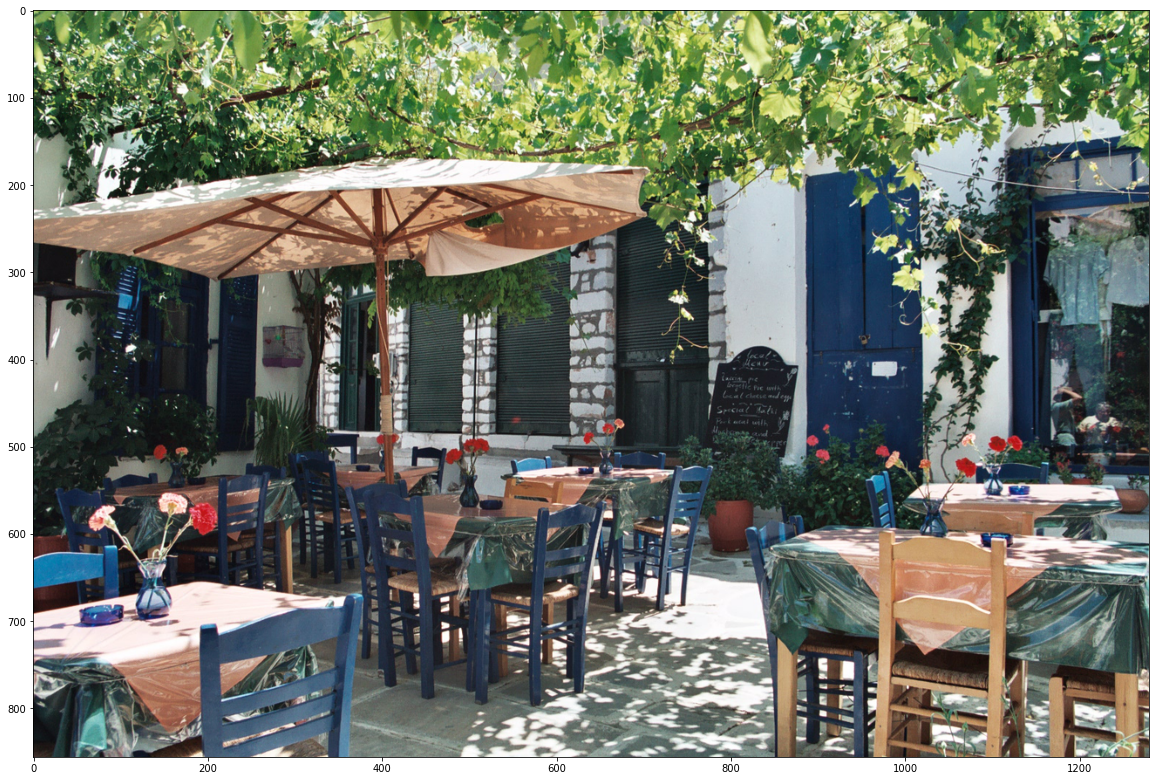

In [3]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"

downloaded_image_path = download_and_resize_image(image_url,
                                                  1280,
                                                  856,
                                                  True)

Apply an object detection module on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2** - high accuracy ([module url](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1))  
* **ssd+mobilenet V2** - small and fast ([module url](https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1))  

In [5]:
module_urls = [
    'https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1',
    'https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1'
]
module_handle = module_urls[0]

detector = hub.load(module_handle).signatures['default']  # TODO: What does hub.load() actually do?

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [9]:
def run_detector(detector, path):
    img = load_img(path)
    
    converted_img = tf.image.convert_image_dtype(img,
                                                 tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)  # inference on the model
    end_time = time.time()
    
    result = {key:value.numpy() for key, value in result.items()}
    
    print('Found {} objects'.format(len(result['detection_scores'])))
    print('Inference time: {}'.format(end_time - start_time))
    
    image_with_boxes = draw_boxes(img.numpy(),
                                  result['detection_boxes'],
                                  result['detection_class_entities'],
                                  result['detection_scores'])
    
    display_image(image_with_boxes)

Found 100 objects
Inference time: 1.055722713470459


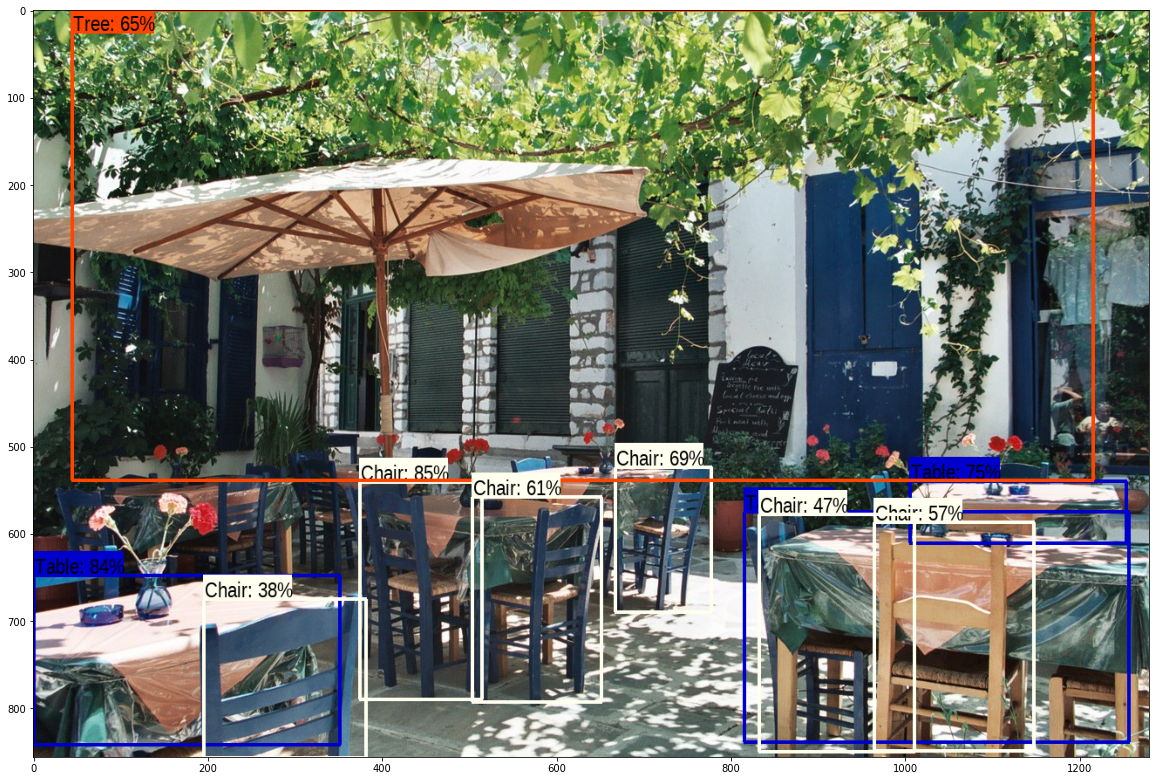

In [10]:
run_detector(detector, downloaded_image_path)

## Inference

In [11]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_objects(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print('Inference time: ', end_time - start_time)

Image downloaded to /tmp/tmpzd3vjkv8.jpg
Found 100 objects
Inference time: 1.9133491516113281
Inference time:  2.349780559539795


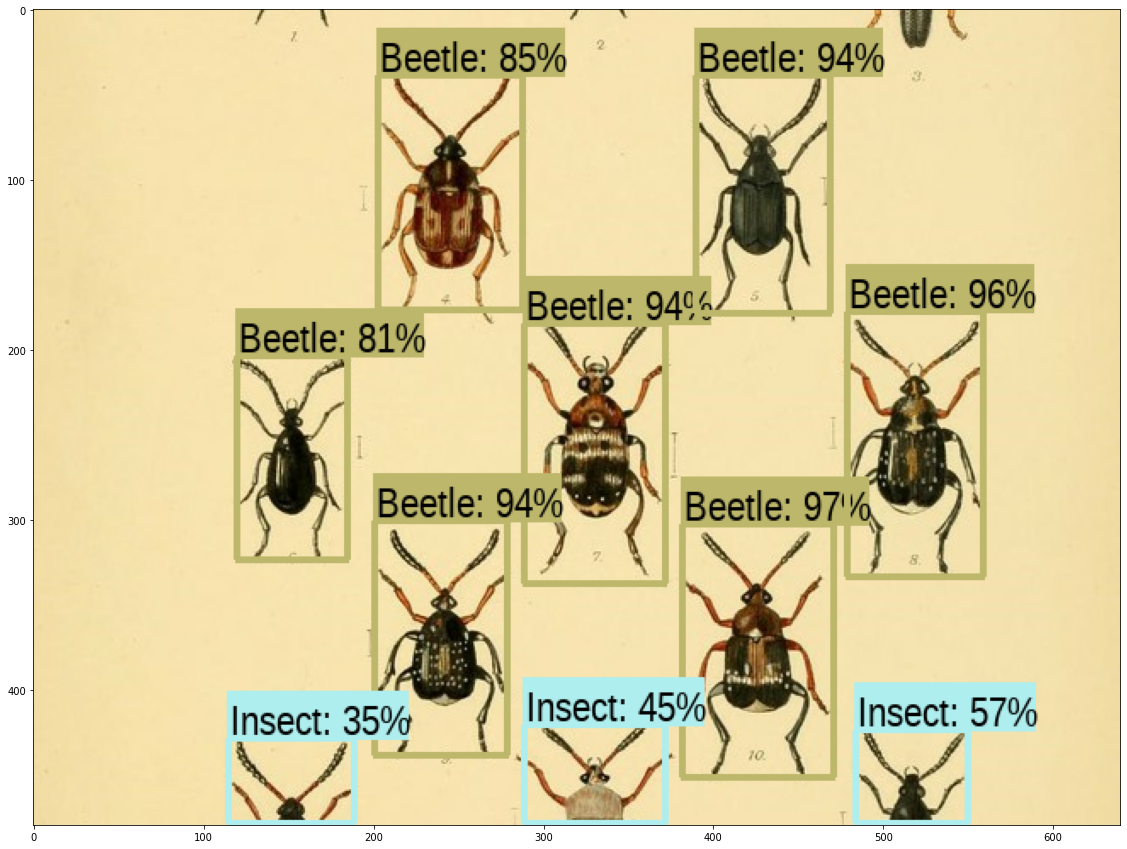

In [12]:
detect_objects(image_urls[0])

Image downloaded to /tmp/tmpmzoh7esm.jpg
Found 100 objects
Inference time: 1.0596489906311035
Inference time:  1.4303793907165527


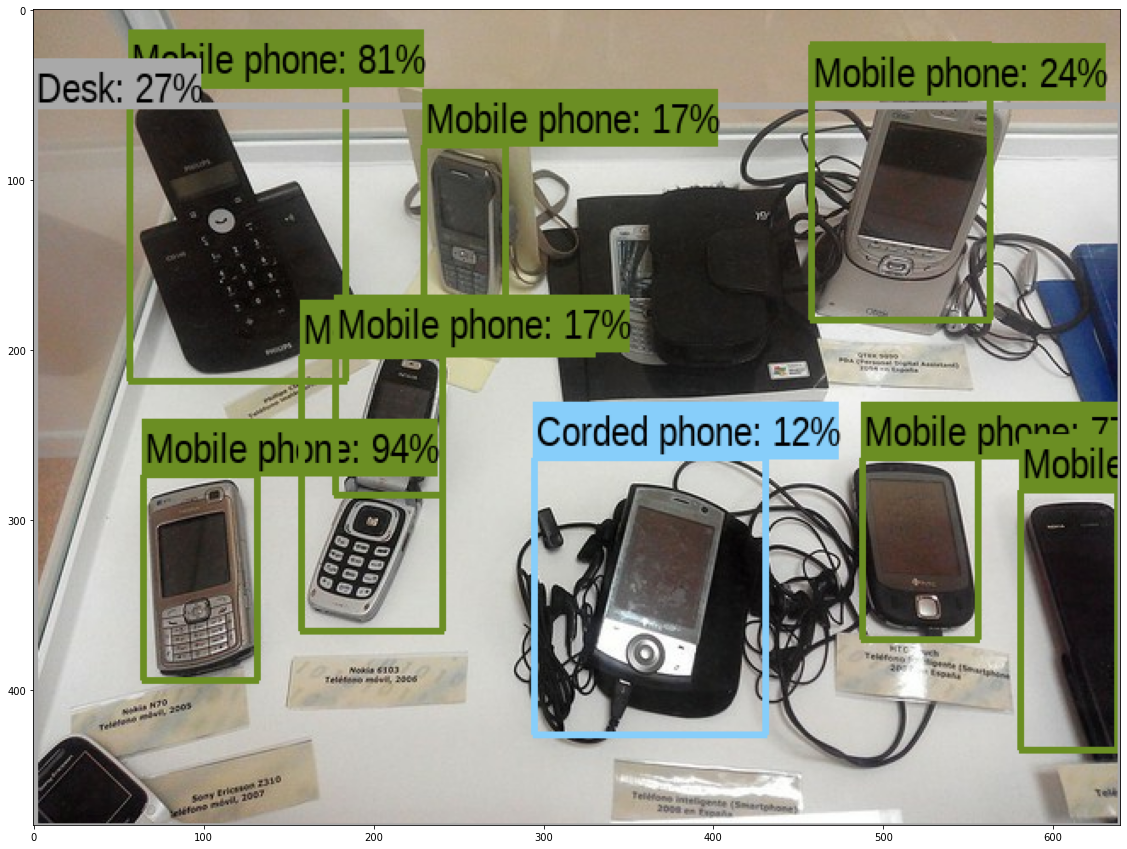

In [13]:
detect_objects(image_urls[1])

Image downloaded to /tmp/tmp_jsjkqph.jpg
Found 100 objects
Inference time: 0.9987766742706299
Inference time:  1.5526556968688965


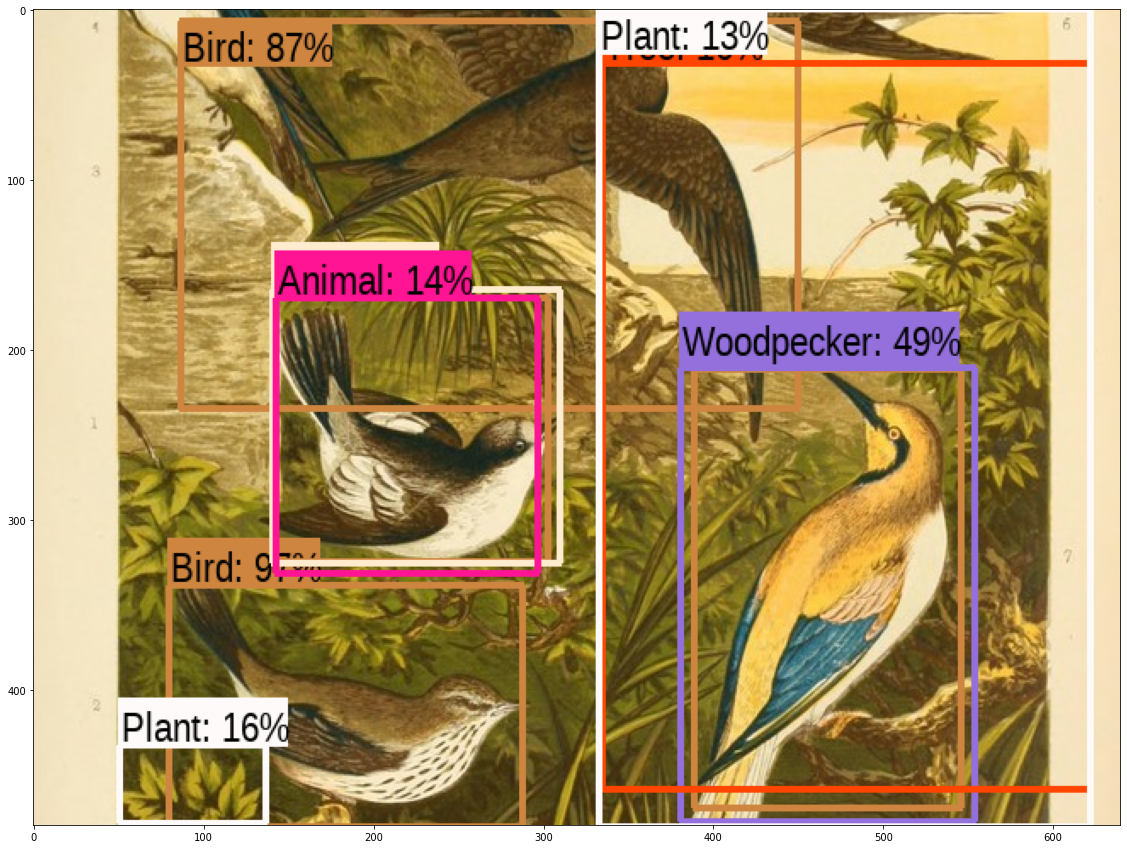

In [14]:
detect_objects(image_urls[2])